# Mod 4 Project: Zillow Housing Data Time Series Modeling & Forecasting

Student: Doug Steen

Instructor: James Irving, PhD

Cohort: ds_ft_10072019

Project Review Date: 1/18/2020

## Background & Purpose

A fictional real estate investment company has requested assistance with the following question:

- What are the five best zip codes to invest in?

For this study, I am using a Zillow Housing Dataset, obtained from Zillow's research page (https://www.zillow.com/research/data/). The raw dataset is located in this repository ('zillow_data.csv'). This dataset contains monthly average home values for nearly every zip code in the U.S., with most zip codes having data from 1996 - 2018.

### Target Region: Tarrant County, TX

The scope of this analysis is limited to the zip codes in Tarrant County, Texas which have available measurements for the full data range (1996 - 2018). Tarrant County encompasses the western portion of the Dallas-Fort Worth (DFW) Metroplex, and most notably contains the cities of Fort Worth and Arlington.
    
### Method

Modeling and forecasting of home values using ARIMA (Auto-regressive Integrated Moving Average) time series analysis techniques.

### Selection Criteria:

The five 'best' zip codes for investment in Tarrant County will be selected based on the following criteria:
    
-3 year forecasted return on investment (ROI)
    
-Confidence interval of the ROI forecast
    
-Quality of model prediction using a train-test split of Zillow data



## Import Libraries / Packages

In [1]:
# Import cohort package
#!pip install -U fsds_100719
import warnings
from fsds_100719.imports import *
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm_notebook

# Display all columns of large dataframes
pd.set_option('display.max_columns', 0)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set default plot style
plt.style.use('seaborn-darkgrid')
%matplotlib inline

fsds_1007219  v0.6.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


## Functions
melt_data: Converts the raw Zillow housing data df from long to wide format (making it more time series-friendly)

arima_grid_search: Finds best fit ARIMA/SARIMA model orders (pdq(s)) for a zip code based on minimizing the AIC

predict_arima: Makes an ARIMA prediction on test portion of a time series, calculates metrics MAPE and R^2 to evaluate fit

forecast_arima: Makes an ARIMA forecast into future beyond a time series, calculates ROI and 95% CL of ROI over given period

### melt_data

In [2]:
def melt_data(df):  # formerly called it melt_data_student with REED
    """
    Melts Zillow Home MeanValue dataframe from long to wide format, in preparation for time series analysis.

    Parameters
    ----------
    df : dataframe
        Zillow dataframe to be converted to wide format

    Returns
    -------
    Melted (wide format) dataframe
    """

    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])

    return melted

### arima_grid_search

In [ ]:
def arima_grid_search(df, zip_code, p, d, q, seasonal=False, train_test=True,
                      train_end='2015-04', show_iters=False):
    """Performs a grids search for optimized pdq(s) orders for fitting a best ARIMA or SARIMA model to Zillow time series by minimizing AIC.

    Parameters
    ----------
    df : dataframe
        dataframe containing time series data (can also include other columns)
    zip_code : int
        zip code to fit the ARIMA or SARIMA model
    p: range or array-like
        AR (p) orders to provide to grid search
    d: range or array-like
        Differencing (d) orders to provide for grid search
    q: range or array-like
        MA (q) orders to provide for grid search
    seasonal : bool
        If True, allows for incorporation of seasonal modeling components with SARIMA
        (Default = False)
    train_test : bool
        If True, specifies that the model should be fit to the train portion of a train-test split of time series.
        If False, model is fit to the entire time series provided.
        (Default = True)
    train_end : str
        Date to mark the end of the training data split (this assumes that test data will be only most recent data)
        (Default = '2015-04')
    show_iters : bool
        If True, prints AIC for each iteration through combinations of model orders
        (Default=False)

    Returns
    -------
    Zip code of selected time series, pdq(s) orders and AIC of the best fit model.
    """
    import statsmodels.api as sm
    from tqdm import tqdm_notebook
    import itertools

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Get only time series object for specified zip code
    df_zip = df.loc[df['RegionName'] == zip_code]

    ts_zip = df_zip.drop(['RegionID', 'RegionName', 'City',
                          'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

    ts_zip.set_index('Month', inplace=True)

    # If arima model is being fit as part of a train-test split, define correct training interval
    if train_test:
        ts_zip = ts_zip[:train_end]

    results = []
    
    # If seasonal is False, SARIMAX function will run as an ARIMA model
    if seasonal == False:
        for i in tqdm_notebook(pdq, desc=f'{zip_code} Grid Search Progress'):
            # Try - except to move to next possibility if model cannot envforce stationarity/invertibility
            try:
                model = sm.tsa.SARIMAX(ts_zip, order=i)
                out = model.fit()
                aic = out.aic
                results.append([i, aic])
            except:
                continue
            # Print results of each grid search iteration if show_iters is True
            if show_iters == True:
                print([i, aic])
                
        # Place all results into a dataframe, and return only the minimum result
        results_df = pd.DataFrame(results, columns=['pdq', 'aic'])
        min_result = results_df.loc[results_df['aic'].idxmin()]
        return zip_code, min_result
    
    # If seasonal is True, function runs as a SARIMA model, and PDQs are considered for seasonal componenet
    else:
        pdqs = [(x[0], x[1], x[2], 12) for x in pdq]
        for i in tqdm_notebook(pdq, desc=f'{zip_code} Grid Search Loop Progress'):
            for j in tqdm_notebook(pdqs, desc=f'{zip_code} Grid Search Sub-Loop Progress'):
                # Try - except to move to next possibility if model cannot envforce stationarity/invertibility
                try:
                    model = sm.tsa.SARIMAX(ts_zip, order=i, seasonal_order=j)
                    out = model.fit()
                    aic = out.aic
                    results.append([i, j, aic])
                except:
                    continue
                # Print results of each grid search iteration if show_iters is True   
                if show_iters == True:
                    print([i, j, aic])
        
        # Place all results into a dataframe, and return only the minimum result
        results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
        min_result = results_df.loc[results_df['aic'].idxmin()]
        return zip_code, min_result

### predict_arima

In [ ]:
def predict_arima(df, zip_code, train_end, test_begin, test_end, pdq, plot=False):
    """Fits an ARIMA model to training data and makes a prediction on testing data for a given zip code's time series data. Returns MAPE
    and R^2 of model test predictions.

    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing desired time series data for all zip codes
    zip code : int
        Desired zip code for model fit and prediction
    train_end : str
        Date to signify end of training (model fit) portion (Assumed that training data is at beginning of ts)
    test_begin : str
        Date to signify beginning of test portion (Model predictions will begin with this date to end of time series)
    test_end : str
        Date to signify end of test portion (Model predictions will end with this date in time series)
    pdq : tuple
        Tuple of the form (p, d, q) to serve as ARIMA model parameters
    plot : bool
        If True, also returns plot of time series and model prediction with 95% conf interval
        (Default = False)

    Returns
    -------
    Summary dataframe containing the zip code, pdq orders, and MAPE / R^2 of model test predictions.
    """
    import statsmodels.api as sm
    from sklearn.metrics import r2_score

    # Get only time series object for specified zip code
    df_zip = df.loc[df['RegionName'] == zip_code]

    ts_zip = df_zip.drop(['RegionID', 'RegionName', 'City',
                          'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

    ts_zip.set_index('Month', inplace=True)

    # Define train and test subsets of time series
    ts_zip_train = ts_zip.loc[:train_end]
    ts_zip_test = ts_zip.loc[test_begin:]

    mod = sm.tsa.SARIMAX(ts_zip_train, order=pdq)
    output = mod.fit()

    # Get predictions for test portion of data
    pred_test = output.get_prediction(start=test_begin, end=test_end)
    pred_train = output.get_prediction(start='1996-04', end='2015-04')
    
    pred_conf = pred_test.conf_int()

    # Model prediction performance on test data
    y_hat_test = pred_test.predicted_mean.values
    y_hat_train = pred_train.predicted_mean.values
    
    y_test = ts_zip_test.values.ravel()
    y_train = ts_zip_train.values.ravel()

    # Creating train-test prediction plot with conf interval if plot is selected
    if plot == True:

        plt.rcParams["figure.figsize"] = [8, 5]
        ax = ts_zip.plot(color='black')
        pred_test.predicted_mean.plot(
            ax=ax, label='Test Prediction', alpha=.5, color='red', lw=5)
        pred_train.predicted_mean.plot(ax=ax, label='Train Prediction', alpha=0.4, color='blue', lw=5)
        ax.fill_between(pred_conf.index,
                        pred_conf.iloc[:, 0],
                        pred_conf.iloc[:, 1], color='red', alpha=.1, label='95% Conf. Int.')
        ax.set_xlabel('Date')
        ax.set_ylabel('Mean Home Value ($)')
        plt.legend(loc=2)
        plt.title(
            f'Model Prediction for {zip_code}: {test_begin} - {test_end}')
        plt.show()

    # MAPE : Mean Absolute Percentage Error
    mape_te = round(
        np.sum(abs((np.subtract(y_test, y_hat_test) / y_test))) / len(y_test), 3)
    
    mape_tr = round(
        np.sum(abs((np.subtract(y_train, y_hat_train) / y_train))) / len(y_train), 3)

    # AIC of model fit to training data
    aic = round(output.aic, 0)

    model_val_summary = pd.DataFrame(columns=['Zip Code', 'pdq', 'AIC (train fit)', 
                                              'MAPE (train fit)', 'MAPE (test fit)'])

    model_val_summary = model_val_summary.append({'Zip Code': str(zip_code), 'pdq': pdq,
                                                  'AIC (train fit)': aic,
                                                  'MAPE (train fit)': mape_tr*100,
                                                  'MAPE (test fit)': mape_te*100}, ignore_index=True)

    return model_val_summary

### forecast_arima

In [ ]:
def forecast_arima(df, zip_code, forecast_begin, forecast_end, pdq, plot=False):
    """
    Produces a time series forecast for Zillow housing data for a zip code based on previously fit ARIMA model paramters.
    
    Parameters
    ----------
    df : pandas dataframe
        Dataframe containing desired time series data for all zip codes
    zip code : int
        Desired zip code for model fit and prediction
    forecast_begin : str
        Date to begin model forecast
    forecast_end : end
        Date to end model forecast
    pdq : tuple
        Tuple of the form (p, d, q) to serve as ARIMA model parameters
    plot : bool
        If True, also returns plot of time series and model forecast with 95% conf interval
        (Default = False)
        
    Returns
    -------
    Summary dataframe containing the ROI and ROI 95% confidence interval for zip code's forecasted period.
    """
    import statsmodels.api as sm

    # Get only time series object for specified zip code
    df_zip = df.loc[df['RegionName'] == zip_code]

    ts_zip = df_zip.drop(['RegionID', 'RegionName', 'City',
                          'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

    ts_zip.set_index('Month', inplace=True)

    ts_zip.index = pd.DatetimeIndex(ts_zip.index.values,
                                    freq='MS')

    # Generate forecast arima model object
    fc_model = sm.tsa.SARIMAX(ts_zip, order=pdq)

    # Fit model
    fc_output = fc_model.fit()

    # Obtain model forecast for desired time period, and confidence interval
    forecast = fc_output.get_prediction(start=forecast_begin, end=forecast_end)
    fc_conf = forecast.conf_int()

    # Creating forecast plot with conf interval if plot is selected
    if plot == True:

        plt.rcParams["figure.figsize"] = [8, 5]
        ax = ts_zip.plot(color='black', lw=3)
        forecast.predicted_mean.plot(
            ax=ax, label='Forecast Prediction', alpha=.9, color='green', lw=3)
        ax.fill_between(fc_conf.index,
                        fc_conf.iloc[:, 0],
                        fc_conf.iloc[:, 1], color='green', alpha=.1, label='95% Conf. Int.')
        ax.set_xlabel('Date')
        ax.set_ylabel('Mean Home Value ($)')
        plt.legend(loc=2)
        plt.title(
            f'Model Forecast for {zip_code}: {forecast_begin} - {forecast_end}')
        plt.show()

    # Calculate 3 year ROI for the forecast
    # Initial value
    init_val = ts_zip.values[-1]

    # Final forecasted value after 3 year forecast
    f_val = forecast.predicted_mean[-1]

    ROI = np.round(((f_val - init_val) / init_val)[0], 3)

    # Calculate lower & upper 95% confidence ROI values

    # lower bound
    l_f_val = fc_conf['lower MeanValue'][-1]

    low_ROI = np.round(((l_f_val - init_val) / init_val)[0], 3)

    # upper bound
    u_f_val = fc_conf['upper MeanValue'][-1]

    high_ROI = np.round(((u_f_val - init_val) / init_val)[0], 3)

    # Size of 95% CL

    size_cl = np.round(high_ROI - low_ROI, 3)

    ROI_summary = pd.DataFrame(columns=[
                               'Zip Code', 'Forecast ROI (%)', 'L 95 ROI (%)', 'H 95 ROI (%)', '95 CL Size (%)'])

    ROI_summary = ROI_summary.append({'Zip Code': str(zip_code), 'Forecast ROI (%)': ROI*100, 'L 95 ROI (%)': low_ROI*100,
                                      'H 95 ROI (%)': high_ROI*100, '95 CL Size (%)': size_cl*100}, ignore_index=True)

    return ROI_summary

## Obtain / Scrub
-Load Zillow dataset

-Reshape data from Wide Format to Long Format

-Subset dataframe for zip codes in Tarrant County, TX containing data in the full range (1996-2018)

In [3]:
# Load Zillow data
df = pd.read_csv('zillow_data.csv')

In [4]:
# Subset data to Tarrant County only, preview Wide Format dataframe
df_tarrant = df.loc[df['CountyName'] == 'Tarrant']
df_tarrant.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
153,91221,76063,Mansfield,TX,Dallas-Fort Worth,Tarrant,154,148100.0,148000.0,147800.0,147700.0,147500.0,147400.0,147300.0,147200.0,147200.0,147100.0,147100.0,147200.0,147500.0,147800.0,148400.0,149000.0,149700.0,150500.0,151300.0,152100.0,152800.0,153400.0,153800.0,154100.0,154500.0,154800.0,155100.0,155300.0,155600.0,155900.0,156200.0,156800.0,157600.0,...,198300,199300,200300,201800,203900,206100,208100,209900,211800,214400,217200,219900,223100,226200,228500,229800,231000,232600,234500,237100,239800,242000,243900,245700,247200,248400,249600,251000,252700,254900,257200,258700,259000,259600,260200,261100,262200,264100,266500,267800
170,91325,76244,Fort Worth,TX,Dallas-Fort Worth,Tarrant,171,139800.0,140100.0,140700.0,141500.0,142300.0,143100.0,143800.0,144600.0,145200.0,145700.0,146400.0,147500.0,148800.0,150300.0,152000.0,153800.0,155600.0,157600.0,159700.0,162100.0,164800.0,167500.0,170200.0,172500.0,174200.0,175000.0,175000.0,174600.0,174200.0,174300.0,175300.0,177300.0,180100.0,...,191800,193000,193900,194600,196200,198600,200800,203000,205500,207700,209200,210700,212600,214700,216700,218900,220900,222500,224400,226500,228500,230100,231600,233100,234900,236700,238400,240100,241700,243600,245600,246700,246700,247500,248500,249700,250300,251000,251400,251300
335,91261,76116,Fort Worth,TX,Dallas-Fort Worth,Tarrant,336,85800.0,86100.0,86500.0,87000.0,87500.0,88000.0,88400.0,88800.0,89000.0,89100.0,89100.0,89000.0,88800.0,88600.0,88300.0,88000.0,87900.0,87800.0,87700.0,87800.0,87900.0,88000.0,88200.0,88400.0,88600.0,88900.0,89200.0,89500.0,89700.0,90000.0,90400.0,90900.0,91400.0,...,134400,135500,136200,135800,135700,136400,137300,138200,139700,141500,143200,144700,146100,147400,148600,150200,152700,155400,156500,156900,157400,157700,157600,158400,160100,161900,163900,166400,168500,170300,172400,174500,176000,178000,180000,181900,183300,185000,186600,187800
550,91291,76179,Fort Worth,TX,Dallas-Fort Worth,Tarrant,551,107100.0,107600.0,108100.0,108800.0,109500.0,110400.0,111300.0,112400.0,113300.0,114200.0,115100.0,115900.0,116600.0,117200.0,117700.0,118100.0,118400.0,118600.0,118800.0,118900.0,118900.0,118900.0,118900.0,119000.0,119200.0,119400.0,119700.0,120100.0,120500.0,120900.0,121300.0,121600.0,121800.0,...,150000,150700,151300,151800,152900,154300,155300,156500,158300,160300,162000,163700,165300,166900,168900,171000,172500,173800,175300,176700,178000,179100,180200,181500,183200,184500,185700,187000,188300,189600,191500,193200,194300,195500,196700,198100,199000,200000,201200,202100
562,91280,76137,Fort Worth,TX,Dallas-Fort Worth,Tarrant,563,117500.0,117500.0,117600.0,117800.0,117900.0,118100.0,118400.0,118600.0,118900.0,119100.0,119400.0,119600.0,119700.0,119800.0,119900.0,120000.0,120000.0,120000.0,120100.0,120100.0,120100.0,120000.0,119900.0,119800.0,119700.0,119500.0,119400.0,119400.0,119500.0,119700.0,119900.0,120100.0,120300.0,...,144100,145100,145500,145500,145900,146700,147700,149000,150400,151700,153000,154400,156400,158200,159900,162200,164900,167700,170400,173100,175600,177900,180000,181700,183300,184800,185900,186800,187900,189300,190700,191400,191800,192800,193800,195400,197000,198700,200500,201700


In [5]:
# Melt Tarrant Co. dataframe to Long Format
df_melted = melt_data(df_tarrant)
df_melted

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,91221,76063,Mansfield,TX,Dallas-Fort Worth,Tarrant,154,1996-04-01,148100.0
1,91325,76244,Fort Worth,TX,Dallas-Fort Worth,Tarrant,171,1996-04-01,139800.0
2,91261,76116,Fort Worth,TX,Dallas-Fort Worth,Tarrant,336,1996-04-01,85800.0
3,91291,76179,Fort Worth,TX,Dallas-Fort Worth,Tarrant,551,1996-04-01,107100.0
4,91280,76137,Fort Worth,TX,Dallas-Fort Worth,Tarrant,563,1996-04-01,117500.0
...,...,...,...,...,...,...,...,...,...
15630,91248,76103,Fort Worth,TX,Dallas-Fort Worth,Tarrant,7549,2018-04-01,126300.0
15631,91215,76054,Hurst,TX,Dallas-Fort Worth,Tarrant,7749,2018-04-01,275500.0
15632,91289,76164,Fort Worth,TX,Dallas-Fort Worth,Tarrant,7981,2018-04-01,103600.0
15633,91219,76060,Kennedale,TX,Dallas-Fort Worth,Tarrant,9340,2018-04-01,243200.0


In [6]:
# Check for null / missing values
df_melted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15635 entries, 0 to 15634
Data columns (total 9 columns):
RegionID      15635 non-null int64
RegionName    15635 non-null int64
City          15635 non-null object
State         15635 non-null object
Metro         15635 non-null object
CountyName    15635 non-null object
SizeRank      15635 non-null int64
Month         15635 non-null datetime64[ns]
MeanValue     15635 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 1.2+ MB


No missing values, the Month and MeanValue columns are correct data types for analysis (datetime and float, respectively). I am not attempting to remove any outliers, since the time series should be uniformly spaced for proper analysis.

## Explore

Step 1: Check to see if seasonality is present/obvious, and if it is worth including a seasonal component in the (S)ARIMA models.

Step 2: Check stationarity of time series to see if a 'd' > 0 is needed in the ARIMA model.

Sub-Step 2A: Can I use pandas .diff() and the A-D-Fuller test to determine the best 'd' orders for an ARIMA grid search?

Step 3: Make an informed decision for the grid search to determine reasonable orders for 'p' & 'q' for each zip code.

### Step 1: Check for Seasonality

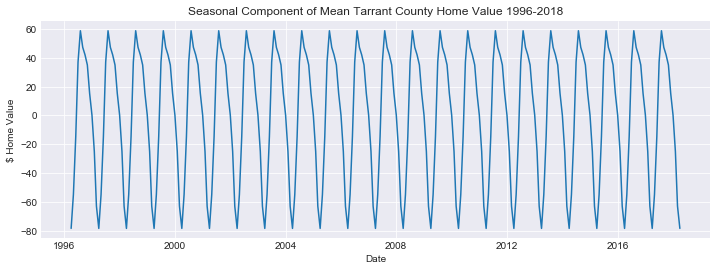

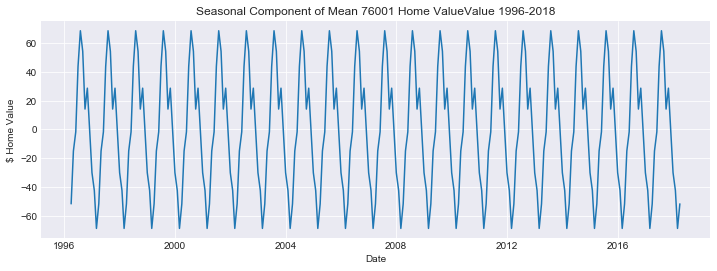

In [7]:
# Step 1: To check for seasonality, I am going to look at the mean time series across all zip codes. 
# Then I will look at seasonality for one zip code (76001) as a gut-check.

df_avg = df_melted.groupby('Month').mean()
ts_avg = df_avg.drop(['RegionID', 'RegionName', 'SizeRank'], axis=1)

# Use seasonal_decompose on Tarrant County mean time series
ts_decomp = seasonal_decompose(ts_avg, model='additive')
ts_seas = ts_decomp.seasonal

# Plot seasonal component
plt.figure(figsize=(12,4))
plt.plot(ts_seas)
plt.xlabel('Date')
plt.ylabel('$ Home Value')
plt.title('Seasonal Component of Mean Tarrant County Home Value 1996-2018')
plt.show();

# Use seasonal_decompose on 76001 time series
df_76001 = df_melted.loc[df_melted['RegionName'] == 76001]
df_76001.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
ts_76001 = df_76001.set_index('Month')

ts_decomp_76001 = seasonal_decompose(ts_76001, model='additive')
ts_seas_76001 = ts_decomp_76001.seasonal

# Plot seasonal component
plt.figure(figsize=(12,4))
plt.plot(ts_seas_76001)
plt.xlabel('Date')
plt.ylabel('$ Home Value')
plt.title('Seasonal Component of Mean 76001 Home ValueValue 1996-2018')
plt.show();

The seasonal component of the data appears to have a range of ~ $140. This does not appear to be worth including a seasonal component in modeling, therefore I will proceed with ARIMA modeling.

### Step 2: Check for Stationarity

In [8]:
# Step 2: Check stationarity of time series to see if a 'd' > 0 is needed in the ARIMA model.
# I am using the adfuller test on each zip code to achieve this.

tarrant_zips = df_melted['RegionName'].unique()
adf_results = []

for zc in tarrant_zips:
    df_z = df_melted.loc[df_melted['RegionName'] == zc]
    df_z.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
    ts_z = df_z.set_index('Month')
    
    adf_p = adfuller(ts_z['MeanValue'])[1] # Grabbing the p-value from adfuller test output
    adf_results.append((zc, adf_p))
    
print('Augmented Dickey Fuller Test p-values (> 0.05 indicates Non-Stationarity)\n')
display(adf_results)

Augmented Dickey Fuller Test p-values (> 0.05 indicates Non-Stationarity)



[(76063, 0.9918753022529935),
 (76244, 0.7927546097803141),
 (76116, 0.987200818131639),
 (76179, 0.9630682235076619),
 (76137, 0.9954512829038924),
 (76051, 1.0),
 (76133, 0.9589796174580881),
 (76010, 0.9252454735071862),
 (76112, 0.9496164094120708),
 (76017, 0.9932352542707764),
 (76039, 0.9990554692835041),
 (76108, 0.9780895768434543),
 (76021, 0.9964020268852687),
 (76107, 0.9988297848760336),
 (76119, 0.7403475709998278),
 (76180, 0.9959583510104025),
 (76248, 0.9942799536081315),
 (76006, 0.9946028272465033),
 (76013, 0.950072502013132),
 (76132, 0.9280422725887152),
 (76131, 0.9634461629075366),
 (76053, 0.9508387291197646),
 (76182, 0.9765438450215789),
 (76117, 0.7939130395810153),
 (76040, 0.9969298909576645),
 (76016, 0.9966354323160508),
 (76014, 0.8274387533149332),
 (76020, 0.975136196385713),
 (76012, 0.9969641974761947),
 (76001, 0.9908513704212778),
 (76109, 0.9990149995830894),
 (76011, 0.6905923701729749),
 (76123, 0.8258140563361148),
 (76140, 0.4596723050767803)

None of the zip code time series are stationary, so a 'd' order of > 0 will need to be included in the ARIMA models.

### Sub-Step 2A: Narrow possible 'd' orders for grid search

In [9]:
# Adjusting the loop to try multiple lags using .diff() and display the results
adf_results = []

for zc in tarrant_zips:
    df_z = df_melted.loc[df_melted['RegionName'] == zc]
    df_z.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
    ts_z = df_z.set_index('Month')
    zip_result = []
    zip_result.append(zc)
    adf_p = adfuller(ts_z['MeanValue'])[1]
    zip_result.append(adf_p)
    
# Checking range of 1 to 5 for 'd' order
    for i in range(1,6):
        ts_z_diff = ts_z.diff(periods=i)
        ts_z_diff.dropna(inplace=True)
        adf_p = adfuller(ts_z_diff['MeanValue'])[1] # Grabbing the p-value from adfuller test output
        zip_result.append(round(adf_p,2))
    adf_results.append(zip_result)

print('Augmented Dickey Fuller Test p-values (> 0.05 indicates Non-Stationarity)\n')
display(adf_results)

Augmented Dickey Fuller Test p-values (> 0.05 indicates Non-Stationarity)



[[76063, 0.9918753022529935, 0.17, 0.39, 0.25, 0.48, 0.35],
 [76244, 0.7927546097803141, 0.13, 0.14, 0.02, 0.09, 0.02],
 [76116, 0.987200818131639, 0.59, 0.69, 0.69, 0.61, 0.66],
 [76179, 0.9630682235076619, 0.43, 0.58, 0.45, 0.65, 0.62],
 [76137, 0.9954512829038924, 0.05, 0.25, 0.29, 0.58, 0.35],
 [76051, 1.0, 0.06, 0.26, 0.19, 0.35, 0.42],
 [76133, 0.9589796174580881, 0.9, 0.79, 0.84, 0.94, 0.92],
 [76010, 0.9252454735071862, 0.51, 0.67, 0.55, 0.66, 0.2],
 [76112, 0.9496164094120708, 0.22, 0.8, 0.78, 0.67, 0.79],
 [76017, 0.9932352542707764, 0.05, 0.28, 0.49, 0.73, 0.46],
 [76039, 0.9990554692835041, 0.62, 0.56, 0.73, 0.7, 0.65],
 [76108, 0.9780895768434543, 0.41, 0.63, 0.4, 0.65, 0.76],
 [76021, 0.9964020268852687, 0.21, 0.23, 0.25, 0.5, 0.65],
 [76107, 0.9988297848760336, 0.04, 0.2, 0.02, 0.29, 0.4],
 [76119, 0.7403475709998278, 0.19, 0.16, 0.21, 0.47, 0.1],
 [76180, 0.9959583510104025, 0.02, 0.31, 0.59, 0.73, 0.65],
 [76248, 0.9942799536081315, 0.43, 0.07, 0.52, 0.31, 0.57],
 [760

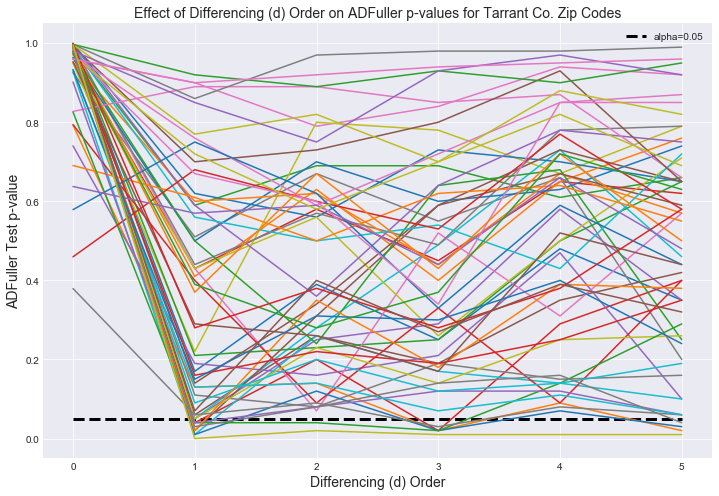

In [10]:
# Figure to visualize adfuller p-values for each zip vs 'd' order

plt.figure(figsize=(12,8))
for z in adf_results:
    plt.plot(z[1:])
plt.hlines(y=0.05, xmin=0, xmax=5, lw=3, linestyle='--', color='black', 
           label='alpha=0.05')
plt.hlines
plt.legend(loc='best')
plt.xlabel('Differencing (d) Order', fontdict={'fontsize': 14})
plt.ylabel('ADFuller Test p-value', fontdict={'fontsize': 14})
plt.title('Effect of Differencing (d) Order on ADFuller p-values for Tarrant Co. Zip Codes', fontdict={'fontsize': 14})
plt.show();

Upon inspection of the plot above, it appears that, IF a time series can be made stationary at alpha = 0.05 by differencing, this usually happens at 'd' = 1, with some time series reaching stationarity at 'd' = 3. Beyond 'd' = 3,
stationarity generally does not appear to improve over lesser 'd' orders.

No time series are stationary at 'd' = 0, therefore, it is clear that some level of differencing is needed.

Based on this information, I will limit the possible 'd' orders in the grid search to range(1,4).

### Step 3: Determine reasonable grid search parameters: 'p' & 'q'

Plot ACF and PACF of 1st order differenced series that COULD be made stationary.

Goal: Determine a ballpark range of 'p' and 'q' orders for arima_grid_search

76137


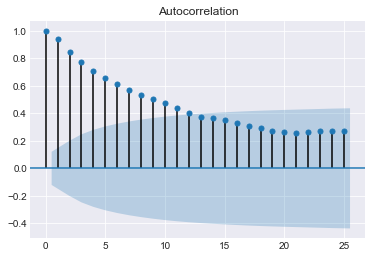

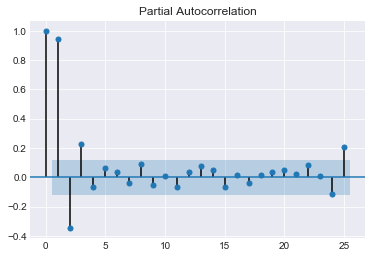

76017


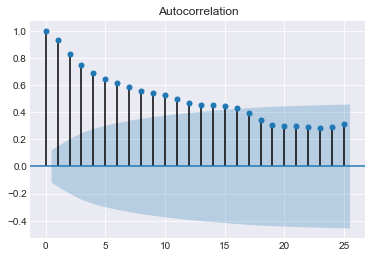

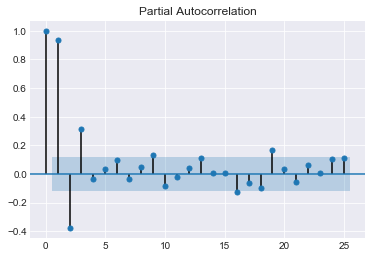

76107


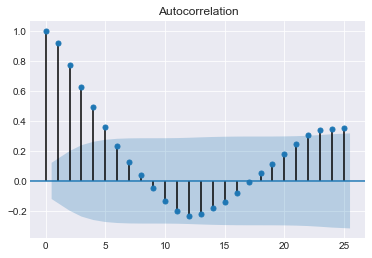

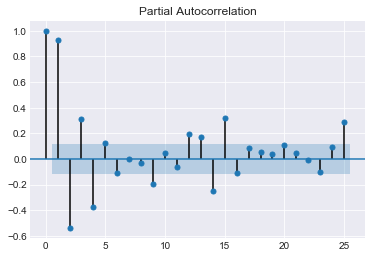

76180


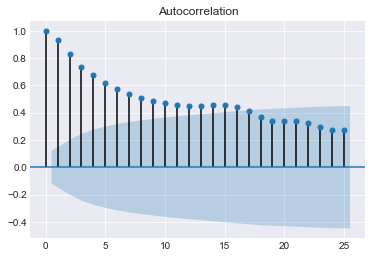

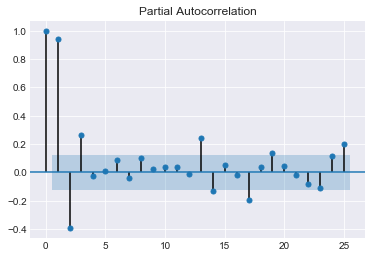

76132


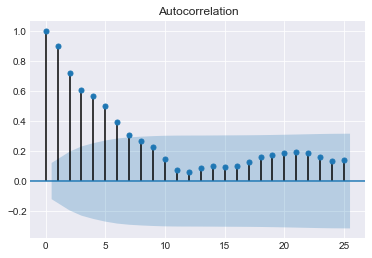

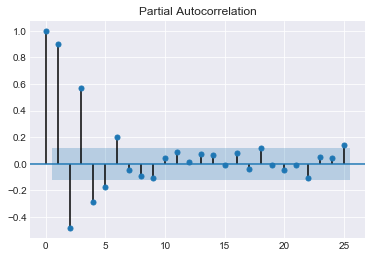

76012


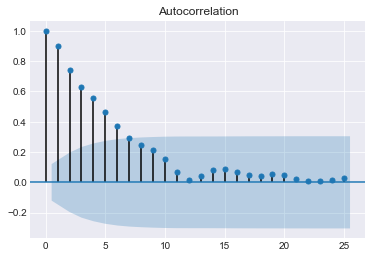

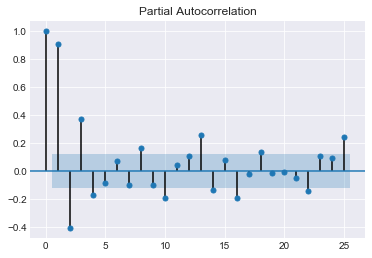

76109


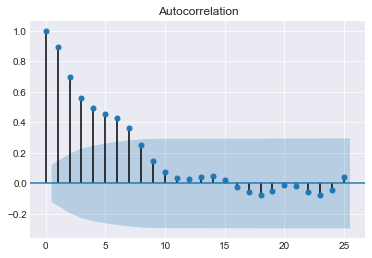

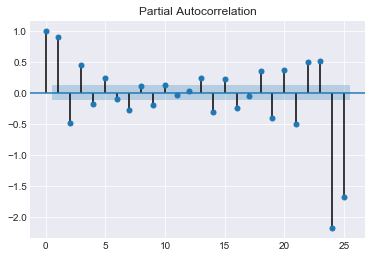

76092


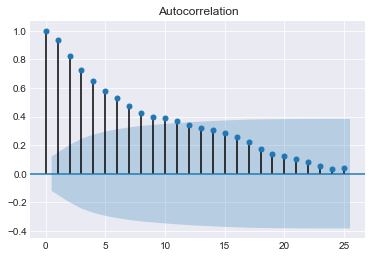

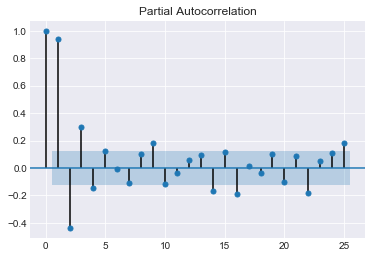

76018


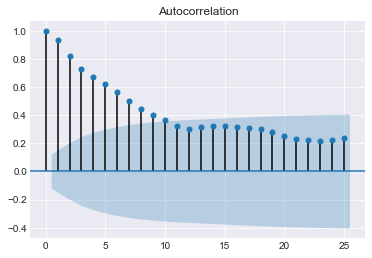

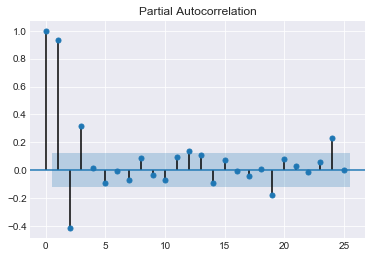

76060


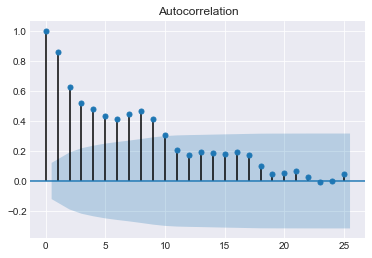

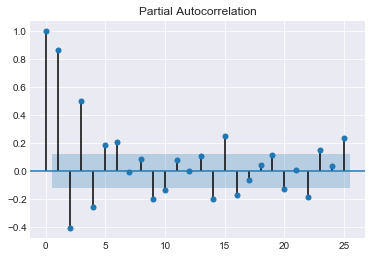

76005


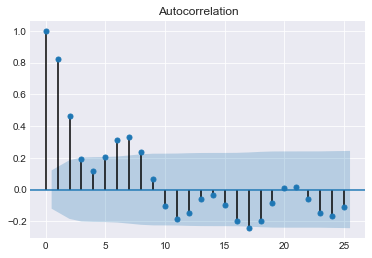

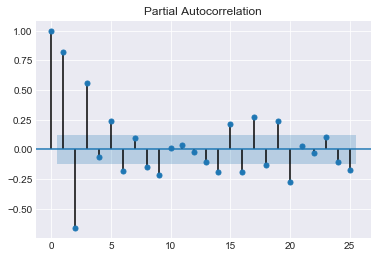

In [11]:
for zc in [76137, 76017, 76107, 76180, 76132, 76012, 76109, 76092, 76018, 76060, 76005]:
    df_zi = df_melted.loc[df_melted['RegionName'] == zc]
    df_zi.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
    ts_zi = df_zi.set_index('Month')
    ts_zi_dif = ts_zi.diff(periods=1).dropna()

    print(zc)
    plot_acf(ts_zi_dif)
    plot_pacf(ts_zi_dif)
    plt.show();

Based on the ACFs and PACFs for stationary (@ d = 1) time series, it appears that PACF typically 'cuts off' at about lag 3 to 6 (though there are some signficant results at higher lag values). Given this information, I will target range(0,7) for the AR(p) model terms.

The ACFs typically tail off, however some experience a sharper 'cut off' at lag 6 - 8. Therefore, I will target range(0,9) for the MA(q) terms.

## Model

### Step 1: Grid Search

-Find best ARIMA model order sfor each zip code using arima_grid_search

In [13]:
# Loop through each zip code in Tarrant county, find best ARIMA pdq order for training data
# Achieved by minimizing AIC for each zip code

# tarrant_zips = df_melted['RegionName'].unique() # iterable list of unique zip codes
# best_tarrant_models = [] # container for storing best model for each zip code

# for zc in tqdm_notebook(tarrant_zips, desc='Total Grid Search Progress'):
#     zip_code, min_result = arima_grid_search(df = df_melted, p = range(0,7), d=range(1,4), q=range(0,9),
#                                              zip_code=zc)
#     best_tarrant_models.append({f'{zip_code}': min_result})
    
# print(best_tarrant_models)



[{'76063': pdq    (4, 2, 2)
aic      3163.35
Name: 117, dtype: object}, {'76244': pdq    (1, 3, 2)
aic         3280
Name: 47, dtype: object}, {'76116': pdq    (4, 2, 5)
aic      3154.75
Name: 122, dtype: object}, {'76179': pdq    (2, 2, 1)
aic      3041.14
Name: 64, dtype: object}, {'76137': pdq    (1, 2, 2)
aic      3075.45
Name: 38, dtype: object}, {'76051': pdq    (0, 2, 0)
aic      3312.87
Name: 9, dtype: object}, {'76133': pdq    (4, 2, 3)
aic      2986.88
Name: 120, dtype: object}, {'76010': pdq    (1, 2, 2)
aic      2960.55
Name: 38, dtype: object}, {'76112': pdq    (5, 2, 4)
aic       2944.9
Name: 148, dtype: object}, {'76017': pdq    (3, 2, 8)
aic      3000.04
Name: 98, dtype: object}, {'76039': pdq    (2, 2, 6)
aic      3257.96
Name: 69, dtype: object}, {'76108': pdq    (4, 2, 3)
aic      3105.81
Name: 120, dtype: object}, {'76021': pdq    (2, 2, 1)
aic      3128.29
Name: 61, dtype: object}, {'76107': pdq    (3, 3, 4)
aic      3416.79
Name: 101, dtype: object}, {'76119': pd

### Step 2: Generate Train / Test Predictions

In [14]:
# Loop to generate dataframe of all model prediction results, ranked by MAPE (%)
# These predictions are being made for the test interval (final 36 months of available data)

# container for holding model prediction evaluation data
df_all_preds = pd.DataFrame([])

# Loop through best model results to make predictions for each
for i in range(len(best_tarrant_models)):
    zip_i = int(list(best_tarrant_models[i].keys())[0])
    pdq_i = list(best_tarrant_models[i].values())[0][0]

    summ_i = predict_arima(df=df_melted, zip_code=zip_i, train_end='2015-04', test_begin='2015-05', test_end='2018-04',
                           pdq=pdq_i, plot=False)

    df_all_preds = pd.concat([df_all_preds, summ_i], axis=0)
    
    # Sort dataframe by Zip Code for easier reading
    df_all_preds = df_all_preds.sort_values('Zip Code')

    # Set zip code as the index    
df_all_preds.set_index('Zip Code', inplace=True)

display(df_all_preds)

,pdq,AIC (train fit),MAPE (train fit),MAPE (test fit)
Zip Code,,,,
76001,"(2, 2, 3)",3085.0,0.8,1.1
76002,"(2, 2, 3)",3093.0,0.8,2.1
76005,"(4, 3, 1)",3814.0,1.4,21.6
76006,"(2, 2, 0)",3323.0,0.8,16.4
76010,"(1, 2, 2)",2961.0,0.8,14.5
76011,"(2, 2, 5)",3098.0,0.8,6.4
76012,"(0, 2, 1)",3304.0,0.8,4.8
76013,"(2, 2, 3)",3021.0,0.8,11.7
76014,"(4, 2, 7)",2946.0,0.8,5.0


Mean Absolute Percentage Error (MAPE) is the metric used here to assess model predictions for the train and test splits for each zip code time series. This metric was selected because it is unitless (unlike MSE, RMSE), allowing for comparison between different zip codes with different overall magnitudes of home values. MAPE is a commonly used evaluation metric in time series forecasting.

Generally, the train MAPE is very good, while the test MAPE is greater for most zip codes. However, several zip codes have a test MAPE that is very near the train MAPE.

### Step 3: Generate 3-Year Forecasts for each Zip Code

In [ ]:
# Loop to generate dataframe of all model forecast results with forecast_arima

df_all_fcs = pd.DataFrame([])  # Container for holding model forecast data

# Loop through best models for each zip code, produce forecast and confidence interval 36 months into future
for i in range(len(best_tarrant_models)):
    try:
        zip_i = int(list(best_tarrant_models[i].keys())[0])
        pdq_i = list(best_tarrant_models[i].values())[0][0]
        fc_sum_i = forecast_arima(df=df_melted, zip_code=zip_i, forecast_begin='2018-05', forecast_end='2021-04',
                                  pdq=pdq_i, plot=False)

        df_all_fcs = pd.concat([df_all_fcs, fc_sum_i], axis=0)
    except:
        continue
# Sort forecast results by Zip (over the total 36 month interval)
df_all_fcs = df_all_fcs.sort_values('Zip Code')
    
# Set Zip Code as the index
df_all_fcs.set_index('Zip Code', inplace=True)

display(df_all_fcs)

## Interpret  - Which zip codes are best? worst?

Step 1: Generate rankings of all zip codes for the following metrics:

1) Predictability of test data (MAPE (%))

2) 3-Year Forecast R.O.I. (% change from last known data point)

3) Uncertainty in R.O.I. Forecast (Size of 95% Confidence Interval of R.O.I. Forecast)

Step 2: Add each ranking above to create zip_rank index

-Zip codes with lower zip_rank index values considered better return investment

-Zip codes with higher zip_rank index values considered worse/riskier investment

In [16]:
# This cell produces final df with prediction evaluation, forecast ROI, and zip code evaluation rank (zip_rank)

# Join test-prediction metrics df and forecast metrics df on zip code
df_pred_fc = df_all_preds.join(df_all_fcs, on='Zip Code')

# Create a ranking column for MAPE (%) (MAPE_rank)
df_pred_fc['MAPE_rank'] = df_pred_fc['MAPE (test fit)'].rank()

# Create a ranking column for Forecast ROI (%) (ROI_rank)
df_pred_fc['ROI_rank'] = df_pred_fc['Forecast ROI (%)'].rank(ascending=False)

# Create a ranking column for 95% CL Size (%) (ROI_uncert_rank)
df_pred_fc['ROI_uncert_rank'] = df_pred_fc['95 CL Size (%)'].rank()

# Combine previous ranking columns to get zip_rank, overall ranking of best zip codes
# Formula: zip_rank = MAPE_rank + ROI_rank + ROI_uncertainty_rank
# The lower the zip_rank, the better the zip code
df_pred_fc['zip_rank'] = df_pred_fc['MAPE_rank'] + df_pred_fc['ROI_rank'] + df_pred_fc['ROI_uncert_rank']

# Sort data based on zip_rank scores
df_pred_fc.sort_values('zip_rank', ascending=True, inplace=True)

# Display the top 5 zip codes
top_5_zips = df_pred_fc[:5]
display(top_5_zips)

# Display the worst 5 zip codes
worst_5_zips = df_pred_fc[-5:]
display(worst_5_zips)

,pdq,AIC (train fit),MAPE (train fit),MAPE (test fit),Forecast ROI (%),L 95 ROI (%),H 95 ROI (%),95 CL Size (%),MAPE_rank,ROI_rank,ROI_uncert_rank,zip_rank
Zip Code,,,,,,,,,,,,
76126,"(4, 2, 3)",3112.0,0.8,1.9,41.1,17.6,64.5,46.9,3.5,6.0,11.0,20.5
76133,"(4, 2, 3)",2987.0,0.8,2.7,38.9,16.8,61.0,44.2,9.0,8.0,5.0,22.0
76014,"(4, 2, 7)",2946.0,0.8,5.0,32.4,11.6,53.1,41.5,15.5,11.0,1.0,27.5
76001,"(2, 2, 3)",3085.0,0.8,1.1,22.2,0.6,43.8,43.2,1.0,33.0,3.0,37.0
76148,"(1, 2, 2)",3048.0,0.8,5.0,50.7,21.0,80.3,59.3,15.5,2.0,24.0,41.5


,pdq,AIC (train fit),MAPE (train fit),MAPE (test fit),Forecast ROI (%),L 95 ROI (%),H 95 ROI (%),95 CL Size (%),MAPE_rank,ROI_rank,ROI_uncert_rank,zip_rank
Zip Code,,,,,,,,,,,,
76132,"(2, 2, 2)",3545.0,0.9,14.3,-2.3,-44.1,39.4,83.5,45.0,54.0,51.0,150.0
76005,"(4, 3, 1)",3814.0,1.4,21.6,-23.9,-180.9,133.1,314.0,55.0,57.0,56.0,168.0
76052,"(2, 3, 2)",3482.0,1.2,48.5,-7.7,-234.1,218.7,452.8,58.0,56.0,57.0,171.0
76244,"(1, 3, 2)",3280.0,1.1,21.1,-101.2,-478.2,275.7,753.9,53.5,59.0,59.0,171.5
76107,"(3, 3, 4)",3417.0,1.2,31.7,-47.4,-284.3,189.6,473.9,57.0,58.0,58.0,173.0


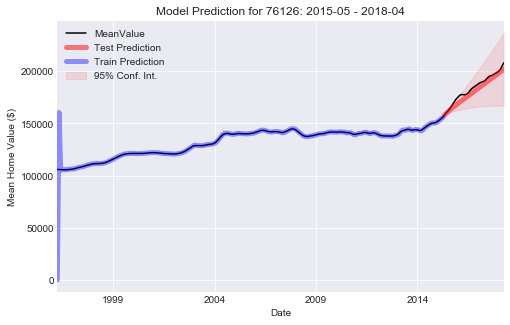

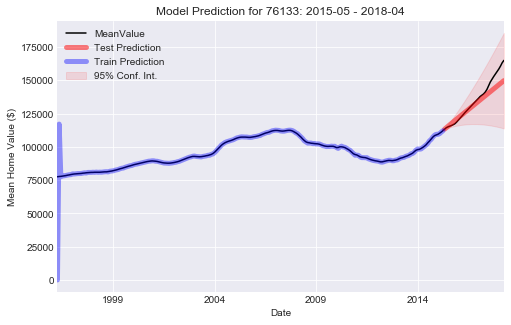

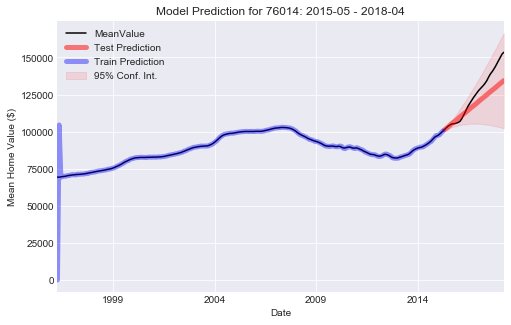

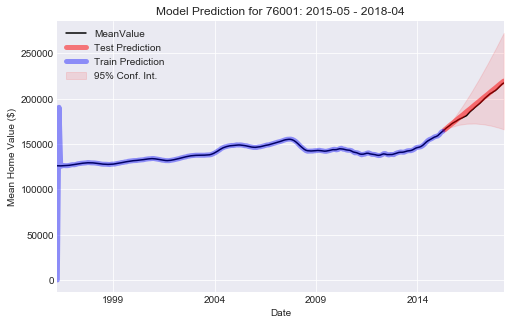

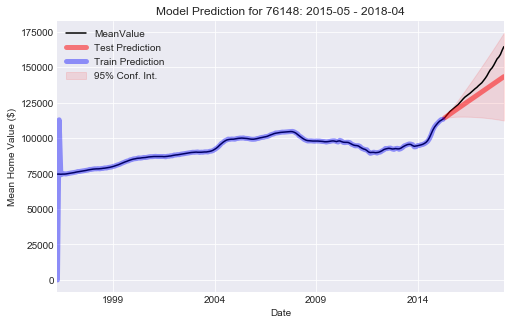

In [17]:
# Get the arima prediction graphs for the top 5 zip codes
for i, row in top_5_zips.iterrows():
    predict_arima(df=df_melted, zip_code=int(i), train_end='2015-04', test_begin='2015-05', test_end='2018-04', 
                  pdq=row['pdq'], plot=True)

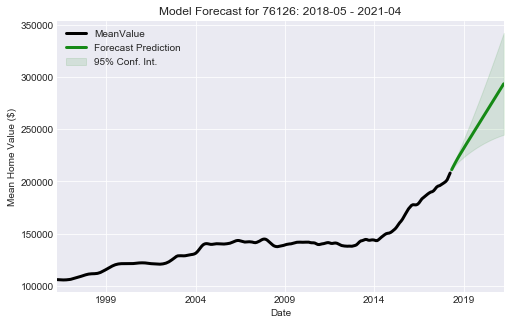

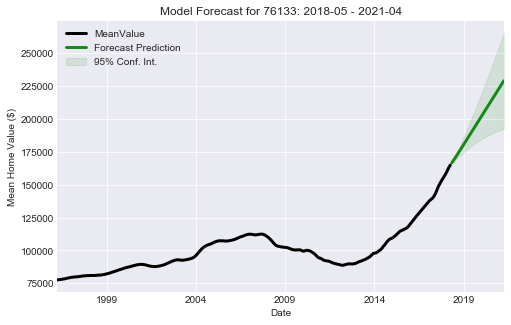

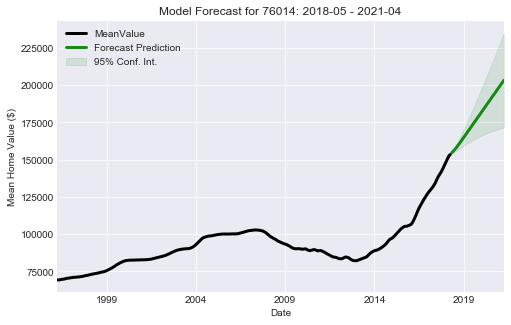

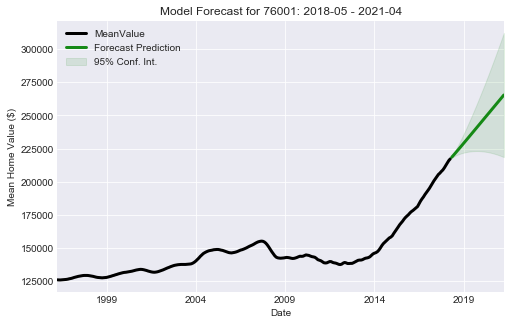

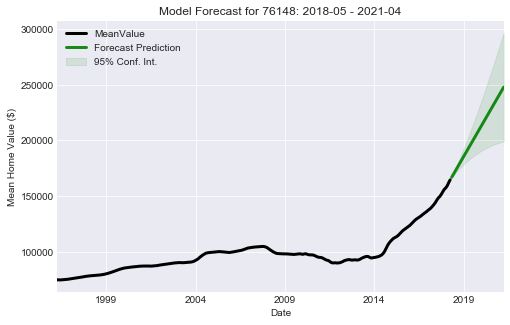

In [18]:
# Get the 3 year arima forecasts for the top 5 zip codes
for i, row in top_5_zips.iterrows():
    forecast_arima(df=df_melted, zip_code=int(i), forecast_begin='2018-05', forecast_end='2021-04', 
                   pdq=row['pdq'], plot=True)

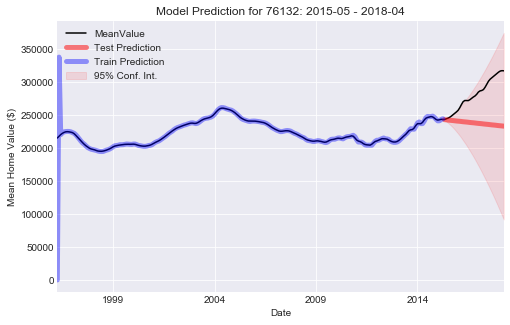

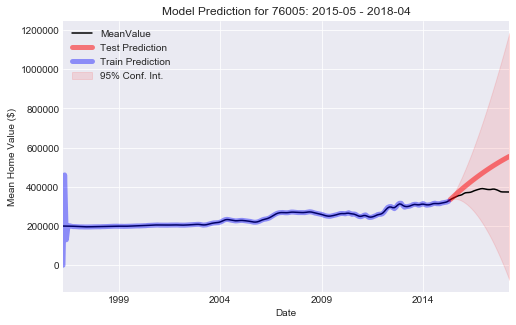

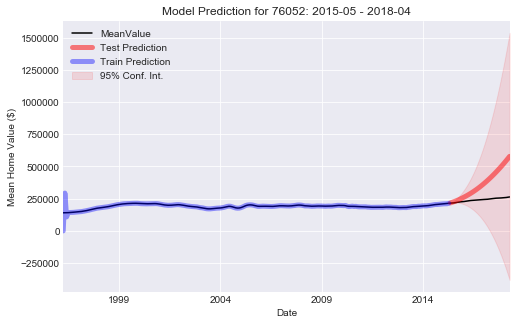

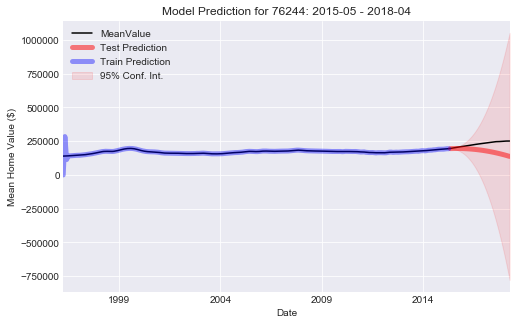

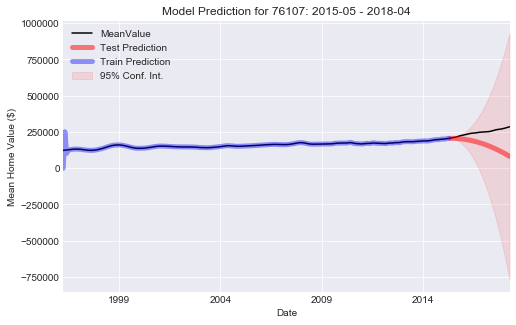

In [19]:
# Get the arima prediction graphs for the worst 5 zip codes
for i, row in worst_5_zips.iterrows():
    predict_arima(df=df_melted, zip_code=int(i), train_end='2015-04', test_begin='2015-05', test_end='2018-04', 
                  pdq=row['pdq'], plot=True)

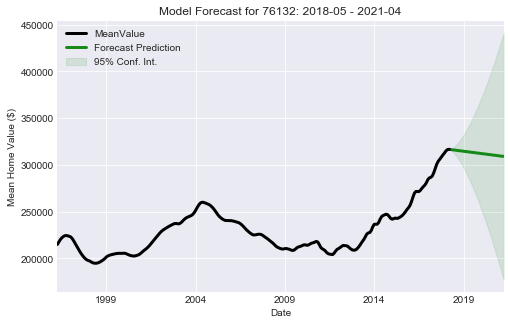

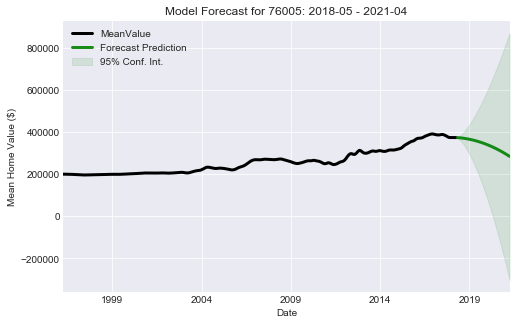

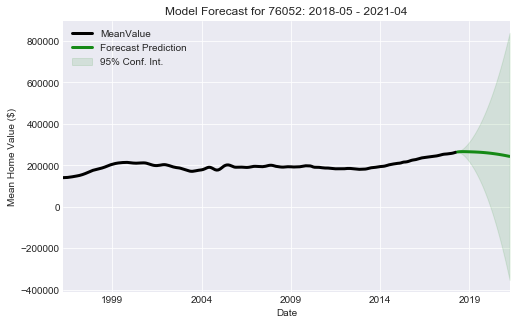

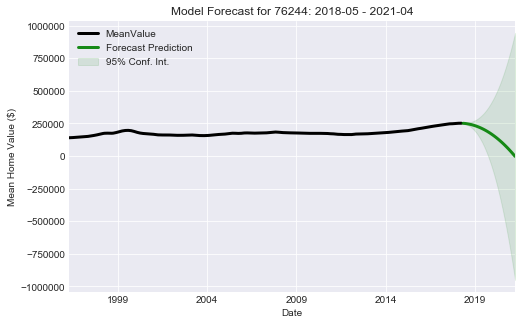

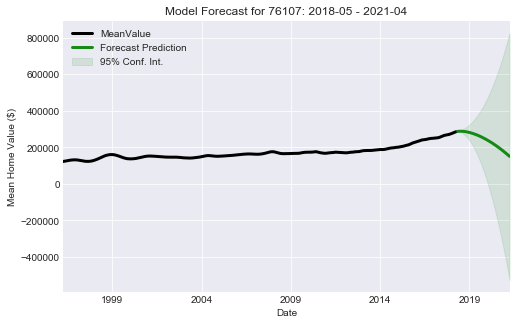

In [20]:
# Get the 3 year arima forecasts for the worst 5 zip codes
for i, row in worst_5_zips.iterrows():
    try:
        forecast_arima(df=df_melted, zip_code=int(i), forecast_begin='2018-05', forecast_end='2021-04', 
                   pdq=row['pdq'], plot=True)
    except:
        print(f'Could not enforce stationarity/invertibility on the model for {i}')
        continue

## Conclusions & Recommendations

There is high variability in the ability of ARIMA models to predict housing prices in 59 Tarrant County zip codes.

Consider these five zip codes for investment (High Predictability + Good R.O.I. Forecast + Low Forecast Uncertainty):

- 76126, 76133, 76014, 76001, 76148

Think twice about these zip codes for investment (Low Predictability + Poor R.O.I. Forecast + High Forecast Uncertainty):

- 76132, 76005, 76052, 76244, 76107

Remember, time series modeling is just one piece of the puzzle. These models, like many, are useful by rarely exactly correct. Also, forecasts may be severely impacted by rapid or dramatic changes in the underlying systems driving housing prices. To name a few:

- Economic boom/recession, natural disasters, government policies, etc.